Initial Setup of libraries, dataframes and directories

In [121]:
# Reading Essential Libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import mplcursors


In [79]:
# Directories
general_directory = '/Users/sanidhyark/Desktop/Agtech/Stream_3_Final_assignment'
precip_directory = 'july_2023_precip_sum.csv'
rm_gis_directory = 'rm_geo_json.geojson'
rm_yields_directory='rm_yields_2004_2023_weighted_avg.csv'


In [80]:
# Loading datasets
df_precip = pd.read_csv(precip_directory)
df_yield = pd.read_csv(rm_yields_directory)
gdf_rm = gpd.read_file(rm_gis_directory)

In [81]:
print(df_yield)

      Matched_RM              Crop  Year  Weighted_Avg_Yield
0      ALEXANDER  ARGENTINE CANOLA  2004           33.775843
1      ALEXANDER  ARGENTINE CANOLA  2005           15.181365
2      ALEXANDER  ARGENTINE CANOLA  2006           37.665256
3      ALEXANDER  ARGENTINE CANOLA  2007           18.119805
4      ALEXANDER  ARGENTINE CANOLA  2008           35.747076
...          ...               ...   ...                 ...
6735  YELLOWHEAD  RED SPRING WHEAT  2019           62.564473
6736  YELLOWHEAD  RED SPRING WHEAT  2020           58.610624
6737  YELLOWHEAD  RED SPRING WHEAT  2021           55.962596
6738  YELLOWHEAD  RED SPRING WHEAT  2022           62.722785
6739  YELLOWHEAD  RED SPRING WHEAT  2023           72.598611

[6740 rows x 4 columns]


Performing ETL and EDA on Drought years in Manitoba


In [112]:
# Count of each crop 
crop_counts = df_yield['Crop'].value_counts()

# Display the counts of each crop
print(crop_counts)

Crop
RED SPRING WHEAT    1727
ARGENTINE CANOLA    1711
OATS                1486
BARLEY              1339
FIELD PEAS           477
Name: count, dtype: int64


Identified 8 drought years in the past 20 years in Manitoba (Less than average rain). 
So filtering for only drought years for this analysis.

In [109]:
# Dropping 'field peas' from the Crop column as its number of data points is very low
df_yield_filtered = df_yield[df_yield['Crop'] != 'FIELD PEAS']

# Filtering for specific *Drought years*
years_to_filter = [2006, 2012, 2014, 2015, 2017, 2020, 2021, 2023]
df_yield_filtered = df_yield_filtered[df_yield_filtered['Year'].isin(years_to_filter)]

# Display the resulting DataFrame
print(df_yield_filtered)

      Matched_RM              Crop  Year  Weighted_Avg_Yield
2      ALEXANDER  ARGENTINE CANOLA  2006           37.665256
8      ALEXANDER  ARGENTINE CANOLA  2012           12.816300
10     ALEXANDER  ARGENTINE CANOLA  2014           27.700309
11     ALEXANDER  ARGENTINE CANOLA  2015           36.103881
13     ALEXANDER  ARGENTINE CANOLA  2017           54.900000
...          ...               ...   ...                 ...
6731  YELLOWHEAD  RED SPRING WHEAT  2015           46.131957
6733  YELLOWHEAD  RED SPRING WHEAT  2017           65.427727
6736  YELLOWHEAD  RED SPRING WHEAT  2020           58.610624
6737  YELLOWHEAD  RED SPRING WHEAT  2021           55.962596
6739  YELLOWHEAD  RED SPRING WHEAT  2023           72.598611

[2497 rows x 4 columns]


In [114]:
# Dropping Null values if there is any
df_yield_final1=df_yield_filtered.dropna()

Finding Meand and Standard Deviation

In [116]:
# Finding historical mean and std for each RM for Drought Years in Manitoba
df_yield_agg=df_yield_filtered.drop(columns='Year').groupby(['Matched_RM', 'Crop'])\
    .agg(['mean', 'std'])

# Renaming Columns
df_yield_agg.columns=['_'.join(col).strip() for col in df_yield_agg.columns]

# Resetting index
df_yield_final=df_yield_agg.reset_index()

print(df_yield_final)

     Matched_RM              Crop  Weighted_Avg_Yield_mean  \
0     ALEXANDER  ARGENTINE CANOLA                36.700139   
1     ALEXANDER            BARLEY                47.666667   
2     ALEXANDER              OATS                92.168665   
3     ALEXANDER  RED SPRING WHEAT                59.935879   
4        ALONSA  ARGENTINE CANOLA                31.299065   
..          ...               ...                      ...   
352   WOODLANDS  RED SPRING WHEAT                54.770436   
353  YELLOWHEAD  ARGENTINE CANOLA                42.336168   
354  YELLOWHEAD            BARLEY                75.341491   
355  YELLOWHEAD              OATS               105.701690   
356  YELLOWHEAD  RED SPRING WHEAT                54.754612   

     Weighted_Avg_Yield_std  
0                 14.831611  
1                 17.853944  
2                 18.847746  
3                 20.841946  
4                 10.334958  
..                      ...  
352               12.420413  
353            

In [117]:
print(df_yield_final.index.names)

[None]


In [118]:
print(df_yield_final.columns)


Index(['Matched_RM', 'Crop', 'Weighted_Avg_Yield_mean',
       'Weighted_Avg_Yield_std'],
      dtype='object')


Plotting Canola production during drought years

/var/folders/6p/pp8cz3090vl4_grtyrm2_w_80000gn/T/ipykernel_4882/2518119994.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  canola_yield = df_yield_final[df_yield['Crop'] == 'ARGENTINE CANOLA']


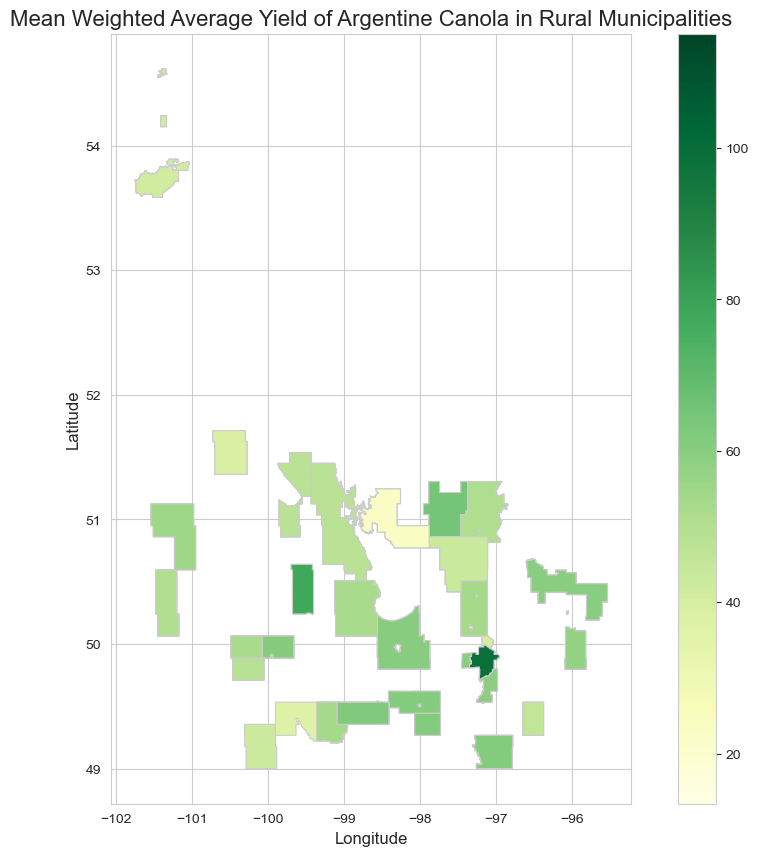

In [122]:

# Filter for "ARGENTINE CANOLA"
canola_yield = df_yield_final[df_yield['Crop'] == 'ARGENTINE CANOLA']

# Merge yield data with the GeoDataFrame
merging_gdf = gdf_rm.merge(canola_yield, on='Matched_RM', how='left')

# Create a figure and axis
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot the GeoDataFrame for only Canola
plot1 = merging_gdf.plot(column='Weighted_Avg_Yield_mean', 
                 cmap='YlGn', 
                 linewidth=0.8, 
                 ax=ax, 
                 edgecolor='0.8',
                 legend=True)

# Add titles and labels
plt.title('Mean Weighted Average Yield of Argentine Canola in Rural Municipalities', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Add dynamic cursor
mplcursors.cursor(plot1, hover=True).connect("add", lambda sel: sel.annotation.set_text(
    f"{merging_gdf['Matched_RM'].iloc[sel.index]}: {merging_gdf['Weighted_Avg_Yield_mean'].iloc[sel.index]:.2f}"
))

# Show the plot
plt.show()




In [124]:
# Filter for Argentine Canola only
canola_data = df_yield_final[df_yield_final['Crop'] == 'ARGENTINE CANOLA']

# Group by 'Matched_RM' and sum the yields
canola_grouped = canola_data.groupby('Matched_RM')['Weighted_Avg_Yield_mean'].sum().reset_index()

# Sorting the DataFrame by yield in descending order
canola_grouped = canola_grouped.sort_values(by='Weighted_Avg_Yield_mean', ascending=False)

# Print the resulting DataFrame
print(canola_grouped)

# Export the DataFrame to a CSV file
canola_grouped.to_csv('canola_production_by_rm.csv', index=False)

        Matched_RM  Weighted_Avg_Yield_mean
84   WEST ST. PAUL                48.375093
59       RHINELAND                45.368594
38          LOUISE                44.147153
43        MONTCALM                44.119868
37           LORNE                43.255715
..             ...                      ...
33          KELSEY                28.197762
3        ARMSTRONG                27.433333
58        REYNOLDS                25.750000
25      GRAHAMDALE                21.678760
83  WEST INTERLAKE                13.400000

[91 rows x 2 columns]


Starting K-means - Elbow, Silhoutte and Spectral clustering on all crops for drought years

In [130]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

Elbow method - Looking for the optimal number of clusters for each of the crop

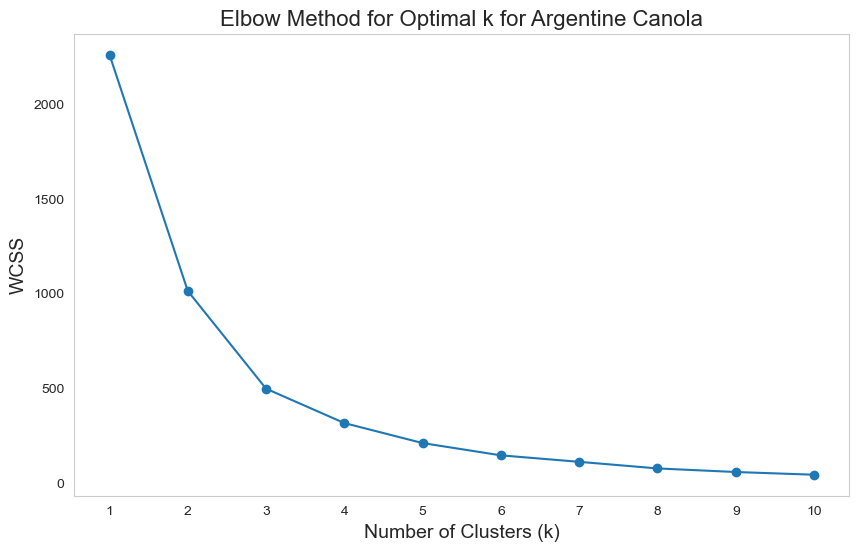

In [137]:
#Elbow method to determine best number of clusters for Argentine Canola

def calculate_wcss(df,crop_name, cluster_range):
    # Filter the DataFrame for the specific crop
    crop_df = df_yield_final[df_yield_final['Crop'] == "ARGENTINE CANOLA"]
    
    # Select relevant columns for clustering (mean yields)
    X = crop_df[['Weighted_Avg_Yield_mean']].values
    
    # Initialize a list to store WCSS values
    wcss = []
    
    # Calculate WCSS for each number of clusters in the specified range
    for i in cluster_range:
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)  # WCSS is stored in inertia
    
    return wcss

# Example usage
crop_name = 'ARGENTINE CANOLA'  # Replace with the crop you want to analyze
cluster_range = range(1, 11)  # Analyzing from 1 to 10 clusters

wcss_values = calculate_wcss(df_yield_filtered, crop_name, cluster_range)

# Plotting the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, wcss_values, marker='o')
plt.title('Elbow Method for Optimal k for Argentine Canola', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('WCSS', fontsize=14)
plt.grid()
plt.xticks(cluster_range)
plt.show()


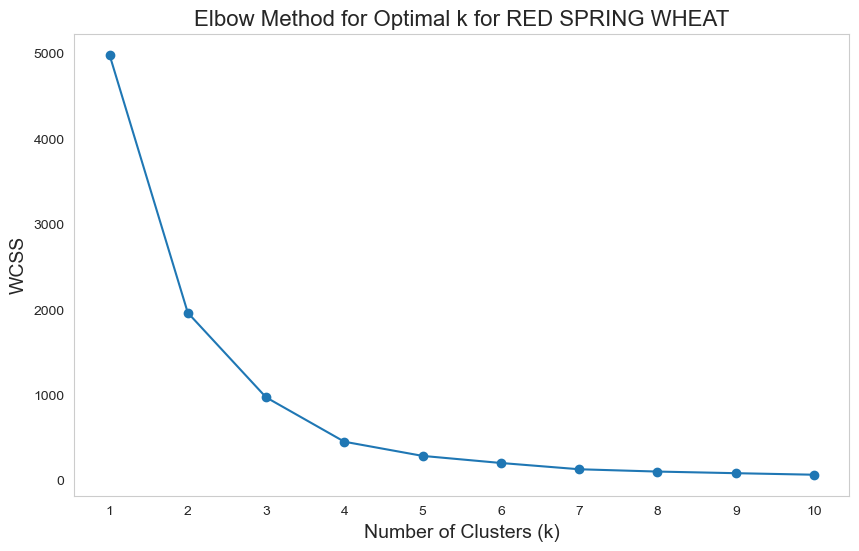

In [220]:
#Elbow method to determine best number of clusters for RED SPRING WHEAT

def calculate_wcss(df, crop_name, cluster_range):
    # Filter the DataFrame for the specific crop
    crop_df2 = df_yield_final[df_yield_final['Crop'] == "RED SPRING WHEAT"]
    
    # Select relevant columns for clustering (mean yields)
    X = crop_df2[['Weighted_Avg_Yield_mean']].values
    
    # Initialize a list to store WCSS values
    wcss = []
    
    # Calculate WCSS for each number of clusters in the specified range
    for i in cluster_range:
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)  # WCSS is stored in inertia
    
    return wcss

# RED SPRING WHEAT
crop_name = 'RED SPRING WHEAT'  # Replace with the crop you want to analyze
cluster_range = range(1, 11)  # Analyzing from 1 to 10 clusters

wcss_values = calculate_wcss(df_yield_filtered, crop_name, cluster_range)

# Plotting the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, wcss_values, marker='o')
plt.title('Elbow Method for Optimal k for RED SPRING WHEAT', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('WCSS', fontsize=14)
plt.grid()
plt.xticks(cluster_range)
plt.show()


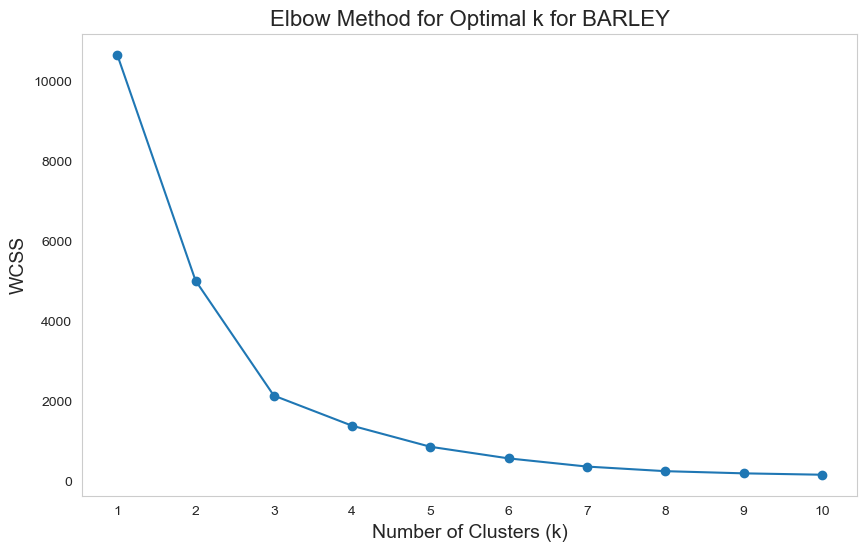

In [139]:
#Elbow method to determine best number of clusters for BARLEY

def calculate_wcss(df, crop_name, cluster_range):
    # Filter the DataFrame for the specific crop
    crop_df3 = df_yield_final[df_yield_final['Crop'] == "BARLEY"]
    
    # Select relevant columns for clustering (mean yields)
    X = crop_df3[['Weighted_Avg_Yield_mean']].values
    
    # Initialize a list to store WCSS values
    wcss = []
    
    # Calculate WCSS for each number of clusters in the specified range
    for i in cluster_range:
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)  # WCSS is stored in inertia
    
    return wcss

# BARLEY
crop_name = 'BARLEY'  # Replace with the crop you want to analyze
cluster_range = range(1, 11)  # Analyzing from 1 to 10 clusters

wcss_values = calculate_wcss(df_yield_filtered, crop_name, cluster_range)

# Plotting the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, wcss_values, marker='o')
plt.title('Elbow Method for Optimal k for BARLEY', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('WCSS', fontsize=14)
plt.grid()
plt.xticks(cluster_range)
plt.show()

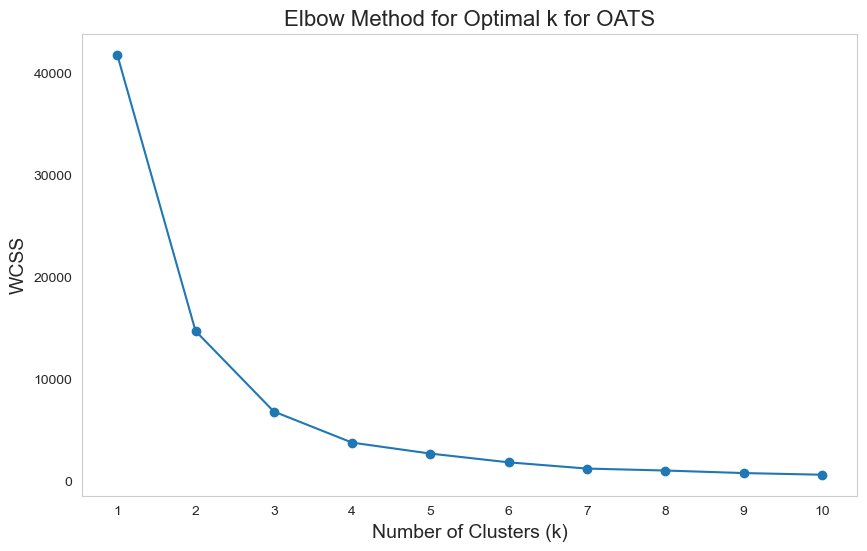

In [140]:
#Elbow method to determine best number of clusters for OATS

def calculate_wcss(df, crop_name, cluster_range):
    # Filter the DataFrame for the specific crop
    crop_df4 = df_yield_final[df_yield_final['Crop'] == "OATS"]
    
    # Select relevant columns for clustering (mean yields)
    X = crop_df4[['Weighted_Avg_Yield_mean']].values
    
    # Initialize a list to store WCSS values
    wcss = []
    
    # Calculate WCSS for each number of clusters in the specified range
    for i in cluster_range:
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)  # WCSS is stored in inertia
    
    return wcss

# OATS
crop_name = 'OATS'  # Replace with the crop you want to analyze
cluster_range = range(1, 11)  # Analyzing from 1 to 10 clusters

wcss_values = calculate_wcss(df_yield_filtered, crop_name, cluster_range)

# Plotting the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, wcss_values, marker='o')
plt.title('Elbow Method for Optimal k for OATS', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('WCSS', fontsize=14)
plt.grid()
plt.xticks(cluster_range)
plt.show()

Silhouette Score to determine what cluster number works best for each crop

Data cleaning

In [147]:
#Found 7 values of STD with null values
print(df_yield_final.isnull().sum())


Matched_RM                 0
Crop                       0
Weighted_Avg_Yield_mean    0
Weighted_Avg_Yield_std     0
dtype: int64


In [148]:
# Replace missing values with 0
df_yield_final.fillna(0, inplace=True)

print(df_yield_final.isnull().sum())



Matched_RM                 0
Crop                       0
Weighted_Avg_Yield_mean    0
Weighted_Avg_Yield_std     0
dtype: int64


Plotting Silhoutte scores for each crop

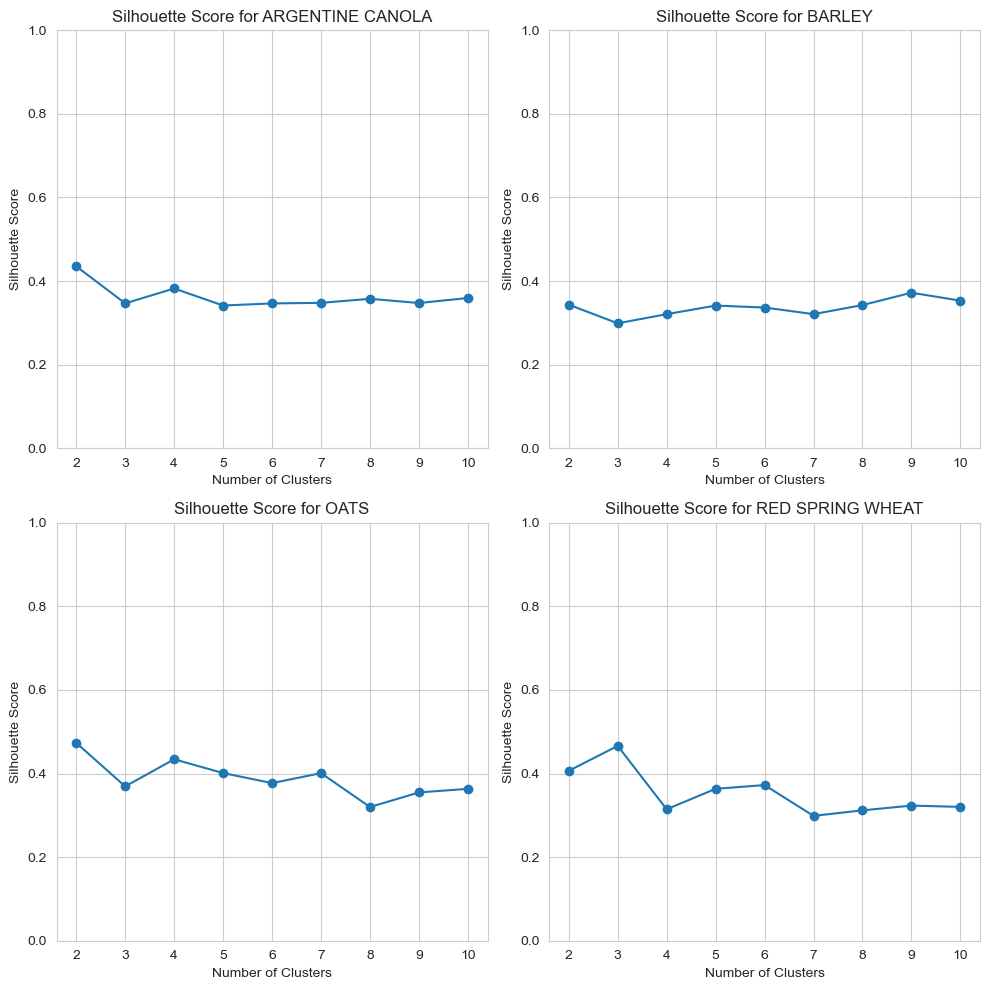

In [149]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Function to calculate silhouette scores for different numbers of clusters
def calculate_silhouette(df_yield_final):
    silhouette_scores = []
    for i in range(2, 11):  # Silhouette score cannot be calculated for 1 cluster
        kmeans = KMeans(n_clusters=i, random_state=42)
        labels = kmeans.fit_predict(df_yield_final)
        score = silhouette_score(df_yield_final, labels)
        silhouette_scores.append(score)
    return silhouette_scores

# List of crops for which you want to plot the silhouette score
crops = ['ARGENTINE CANOLA', 'BARLEY', 'OATS', 'RED SPRING WHEAT']

# Initialize the plot for a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for idx, crop in enumerate(crops):
    # Filter data by crop
    crop_data1 = df_yield_final.loc[df_yield_final['Crop'] == crop]
    
    # Extract the 'Weighted_Avg_Yield_mean' and 'Weighted_Avg_Yield_std' as features
    X = crop_data1[['Weighted_Avg_Yield_mean', 'Weighted_Avg_Yield_std']].values
    
    # Normalize the data using StandardScaler
    scaler = StandardScaler()
    scaled_X = scaler.fit_transform(X)
    
    # Calculate Silhouette scores
    silhouette_scores = calculate_silhouette(scaled_X)
    
    # Plotting each subplot
    row, col = divmod(idx, 2)
    axs[row, col].plot(range(2, 11), silhouette_scores, marker='o')
    axs[row, col].set_title(f'Silhouette Score for {crop}')
    axs[row, col].set_xlabel('Number of Clusters')
    axs[row, col].set_ylabel('Silhouette Score')
    axs[row, col].set_ylim(0, 1)  # Set y-axis limits for better visibility

plt.tight_layout()
plt.show()


Identified these as optimum clustering numbers. The variance in optimal clustering is low since we have taken the average of only 8 years.

In [143]:
print(df_yield_final)

     Matched_RM              Crop  Weighted_Avg_Yield_mean  \
0     ALEXANDER  ARGENTINE CANOLA                36.700139   
1     ALEXANDER            BARLEY                47.666667   
2     ALEXANDER              OATS                92.168665   
3     ALEXANDER  RED SPRING WHEAT                59.935879   
4        ALONSA  ARGENTINE CANOLA                31.299065   
..          ...               ...                      ...   
352   WOODLANDS  RED SPRING WHEAT                54.770436   
353  YELLOWHEAD  ARGENTINE CANOLA                42.336168   
354  YELLOWHEAD            BARLEY                75.341491   
355  YELLOWHEAD              OATS               105.701690   
356  YELLOWHEAD  RED SPRING WHEAT                54.754612   

     Weighted_Avg_Yield_std  
0                 14.831611  
1                 17.853944  
2                 18.847746  
3                 20.841946  
4                 10.334958  
..                      ...  
352               12.420413  
353            

K-means clustering analysis for all crops

In [214]:
# Create a copy of Dataframe without the 'Cluster' column
df_yieldNC = df_yield_final.drop(columns=['Cluster']).copy()


In [215]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Assuming df_yieldNC is your DataFrame
# Step 1: Filter the data if necessary (for example, only Barley)
# This can be omitted if you want to include all crops
# df_filtered = df_yieldNC[df_yieldNC['Crop'] == 'BARLEY']

# Step 2: Select the features for clustering
features = df_yieldNC[['Weighted_Avg_Yield_mean', 'Weighted_Avg_Yield_std']].copy()

# Step 3: Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Step 4: Perform K-means clustering
n_clusters = 3  # You can change this to 4 or any other number
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_yieldNC['Cluster'] = kmeans.fit_predict(X_scaled)

# Step 5: Analyze the results
# Summary of the clusters
cluster_summary = df_yieldNC.groupby('Cluster').agg({
    'Weighted_Avg_Yield_mean': ['mean', 'std'],
    'Weighted_Avg_Yield_std': ['mean', 'std'],
    'Crop': 'count'
}).reset_index()

print(cluster_summary)


  Cluster Weighted_Avg_Yield_mean            Weighted_Avg_Yield_std            \
                             mean        std                   mean       std   
0       0               46.476451  11.008909              10.030002  3.741879   
1       1               78.524332  12.774456              17.443416  4.345063   
2       2               95.491261  20.318212              31.360140  5.344586   

   Crop  
  count  
0   208  
1    98  
2    51  


K-means for wheat

In [217]:
import pandas as pd
from sklearn.cluster import KMeans

# Filter for Red Spring Wheat
red_spring_wheat_data = df_yieldNC[df_yieldNC['Crop'] == 'RED SPRING WHEAT']

# Select relevant features for clustering
X = red_spring_wheat_data[['Weighted_Avg_Yield_mean', 'Weighted_Avg_Yield_std']].copy()

# KMeans clustering for 3 clusters
kmeans_3 = KMeans(n_clusters=3, random_state=42)
red_spring_wheat_data['Cluster_3'] = kmeans_3.fit_predict(X)

# KMeans clustering for 4 clusters
kmeans_4 = KMeans(n_clusters=4, random_state=42)
red_spring_wheat_data['Cluster_4'] = kmeans_4.fit_predict(X)

# Analyze the clusters
cluster_analysis_3 = red_spring_wheat_data.groupby('Cluster_3').agg({
    'Weighted_Avg_Yield_mean': ['mean', 'std'],
    'Weighted_Avg_Yield_std': ['mean', 'std'],
    'Matched_RM': 'count'  # Count of municipalities in each cluster
}).reset_index()

cluster_analysis_4 = red_spring_wheat_data.groupby('Cluster_4').agg({
    'Weighted_Avg_Yield_mean': ['mean', 'std'],
    'Weighted_Avg_Yield_std': ['mean', 'std'],
    'Matched_RM': 'count'  # Count of municipalities in each cluster
}).reset_index()

# Display the analysis
print("Cluster Analysis for 3 Clusters:")
print(cluster_analysis_3)

print("\nCluster Analysis for 4 Clusters:")
print(cluster_analysis_4)


Cluster Analysis for 3 Clusters:
  Cluster_3 Weighted_Avg_Yield_mean           Weighted_Avg_Yield_std  \
                               mean       std                   mean   
0         0               42.545125  6.261672               5.805596   
1         1               56.080216  4.054110              10.907211   
2         2               40.787047  7.453332              15.954515   

            Matched_RM  
        std      count  
0  3.691963          9  
1  2.347705         74  
2  2.663090          9  

Cluster Analysis for 4 Clusters:
  Cluster_4 Weighted_Avg_Yield_mean           Weighted_Avg_Yield_std  \
                               mean       std                   mean   
0         0               41.011143  6.314350               5.065729   
1         1               52.245592  2.446767              10.655052   
2         2               39.002535  7.551604              16.600501   
3         3               59.807695  1.948913              11.232680   

            Ma

/var/folders/6p/pp8cz3090vl4_grtyrm2_w_80000gn/T/ipykernel_4882/2193530926.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  red_spring_wheat_data['Cluster_3'] = kmeans_3.fit_predict(X)
/var/folders/6p/pp8cz3090vl4_grtyrm2_w_80000gn/T/ipykernel_4882/2193530926.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  red_spring_wheat_data['Cluster_4'] = kmeans_4.fit_predict(X)


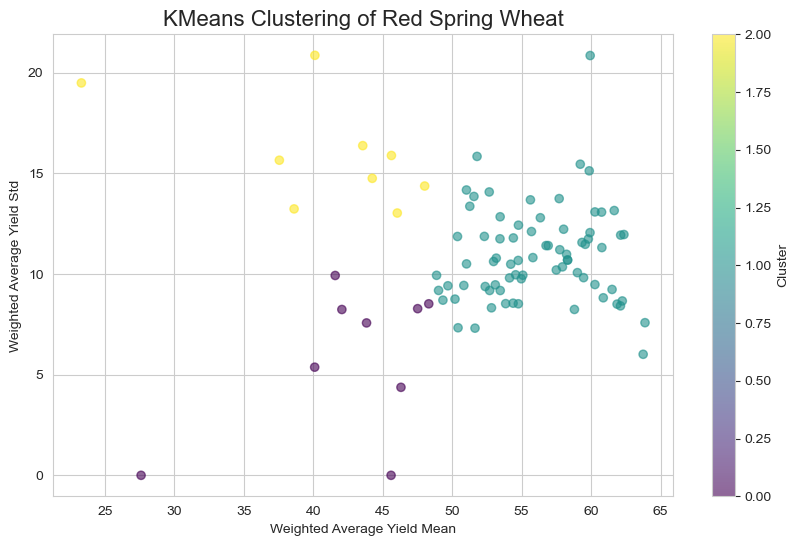

In [218]:
import matplotlib.pyplot as plt

# Plotting the clusters
plt.figure(figsize=(10, 6))
plt.scatter(red_spring_wheat_data['Weighted_Avg_Yield_mean'], 
            red_spring_wheat_data['Weighted_Avg_Yield_std'], 
            c=red_spring_wheat_data['Cluster_3'],  # Change to 'Cluster_4' for 4 clusters
            cmap='viridis', 
            alpha=0.6)
plt.title('KMeans Clustering of Red Spring Wheat', fontsize=16)
plt.xlabel('Weighted Average Yield Mean')
plt.ylabel('Weighted Average Yield Std')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()


<Figure size 1000x600 with 0 Axes>

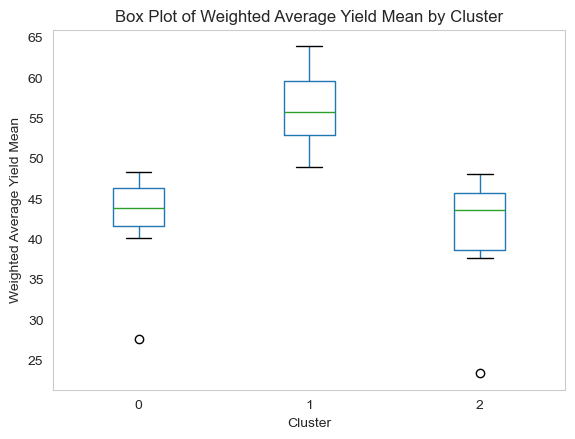

In [219]:
# Box plot for Weighted_Avg_Yield_mean by Cluster
plt.figure(figsize=(10, 6))
red_spring_wheat_data.boxplot(column='Weighted_Avg_Yield_mean', by='Cluster_3', grid=False)
plt.title('Box Plot of Weighted Average Yield Mean by Cluster')
plt.suptitle('')
plt.xlabel('Cluster')
plt.ylabel('Weighted Average Yield Mean')
plt.show()


Spectral clustering of Wheat

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
import plotly.express as px

In [157]:
# Filter for Red Spring Wheat
red_spring_wheat_data = df_yield_final[df_yield_final['Crop'] == 'RED SPRING WHEAT']

# Prepare the data
X = red_spring_wheat_data[['Weighted_Avg_Yield_mean', 'Weighted_Avg_Yield_std']].values

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform Spectral Clustering
n_clusters = 3  # Best number of clusters found from silhouette score
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
red_spring_wheat_data['Cluster'] = spectral.fit_predict(X_scaled)


/var/folders/6p/pp8cz3090vl4_grtyrm2_w_80000gn/T/ipykernel_4882/1708700290.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  red_spring_wheat_data['Cluster'] = spectral.fit_predict(X_scaled)


In [158]:
# Merge the cluster labels back to the GeoDataFrame
gdf_rm['Cluster'] = gdf_rm['Matched_RM'].map(red_spring_wheat_data.set_index('Matched_RM')['Cluster'])


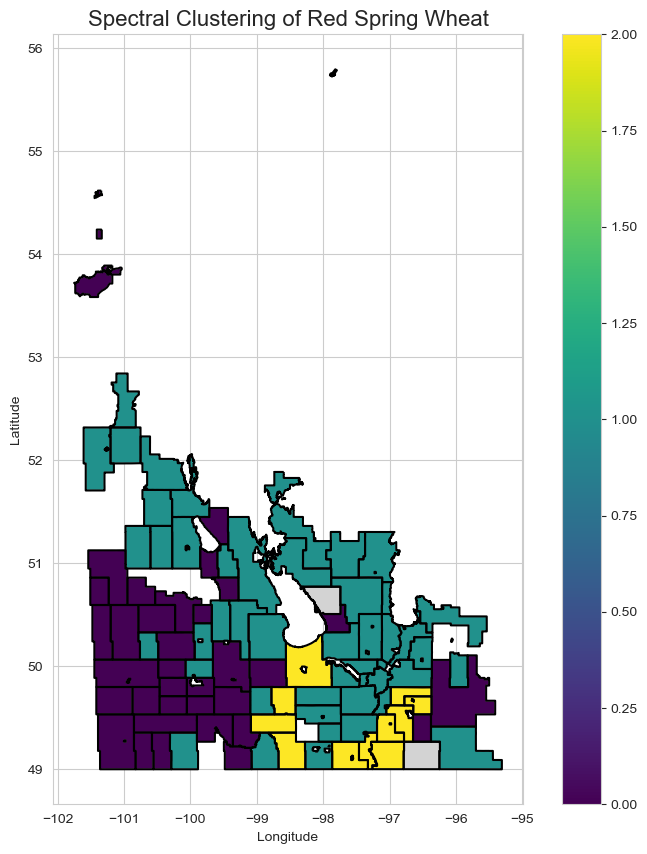

In [163]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Set up the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the GeoDataFrame with clusters
gdf_rm.boundary.plot(ax=ax, color='k')  # Draw the boundaries
gdf_rm.plot(column='Cluster', ax=ax, legend=True, cmap='viridis', 
             missing_kwds={"color": "lightgrey", "label": "Not assigned"})

# Add titles and labels
plt.title('Spectral Clustering of Red Spring Wheat', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


Spectral Clustering for all crops

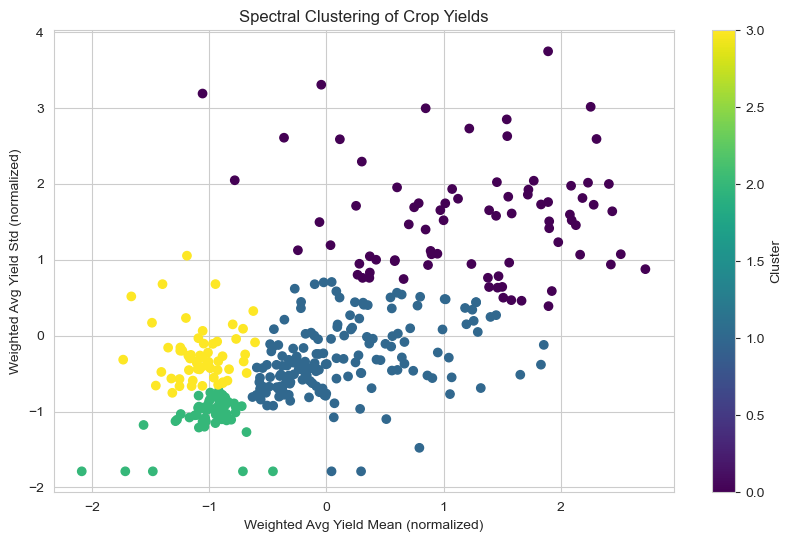

Silhouette Score: 0.32


In [153]:


# Step 1: Prepare the Data
X = df_yield_final[['Weighted_Avg_Yield_mean', 'Weighted_Avg_Yield_std']].values

# Step 2: Normalize the Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply Spectral Clustering
n_clusters = 4  # Changing this number based on Silhoutte Score
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
labels = spectral.fit_predict(X_scaled)

# Step 4: Add the labels to your DataFrame
df_yield_final['Cluster'] = labels

# Step 5: Optionally, visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', marker='o')
plt.title('Spectral Clustering of Crop Yields')
plt.xlabel('Weighted Avg Yield Mean (normalized)')
plt.ylabel('Weighted Avg Yield Std (normalized)')
plt.colorbar(label='Cluster')
plt.show()

# Optional: Calculate silhouette score
silhouette_avg = silhouette_score(X_scaled, labels)
print(f'Silhouette Score: {silhouette_avg:.2f}')


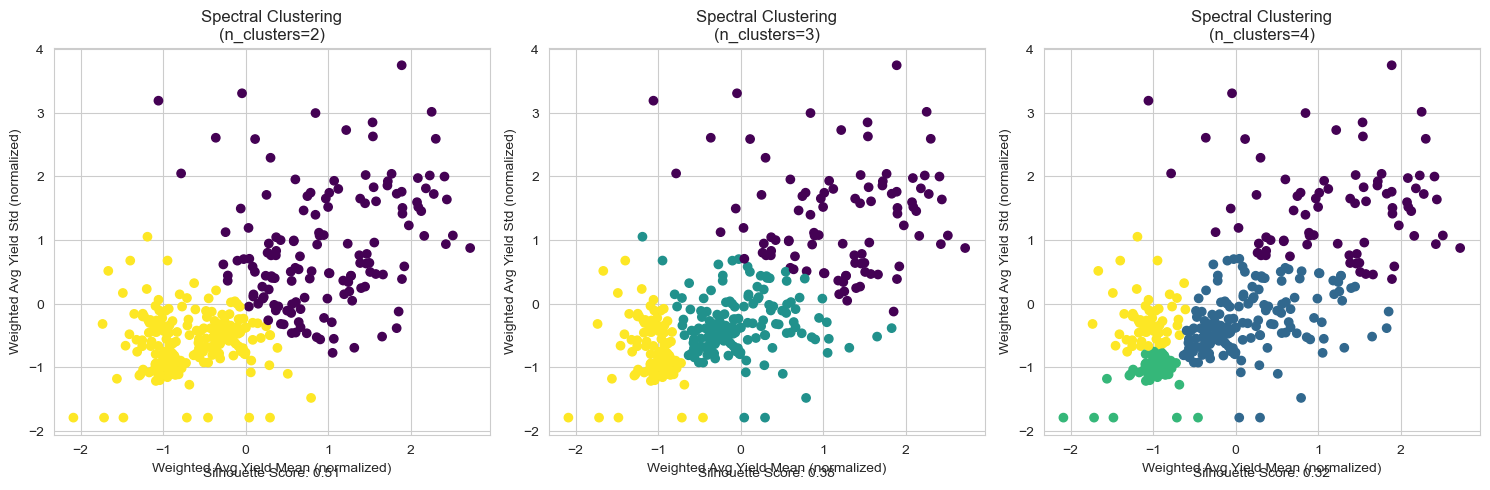

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score

# for df_yield_final drought years crops in Manitoba
def plot_spectral_clustering(df, n_clusters_list):
    # Step 1: Prepare the Data
    X = df[['Weighted_Avg_Yield_mean', 'Weighted_Avg_Yield_std']].values

    # Step 2: Normalize the Data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Create subplots for different numbers of clusters
    fig, axs = plt.subplots(1, len(n_clusters_list), figsize=(15, 5))

    for idx, n_clusters in enumerate(n_clusters_list):
        # Step 3: Apply Spectral Clustering
        spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
        labels = spectral.fit_predict(X_scaled)

        # Step 4: Optionally, add the labels to your DataFrame (if needed)
        df['Cluster'] = labels

        # Plotting the clusters
        axs[idx].scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', marker='o')
        axs[idx].set_title(f'Spectral Clustering\n(n_clusters={n_clusters})')
        axs[idx].set_xlabel('Weighted Avg Yield Mean (normalized)')
        axs[idx].set_ylabel('Weighted Avg Yield Std (normalized)')

        # Optional: Calculate silhouette score
        silhouette_avg = silhouette_score(X_scaled, labels)
        axs[idx].text(0.5, -0.1, f'Silhouette Score: {silhouette_avg:.2f}', ha='center', va='center', transform=axs[idx].transAxes)

    plt.tight_layout()
    plt.show()

# List of different numbers of clusters to visualize
n_clusters_list = [2, 3, 4]  # Adjust as needed

# Call the function
plot_spectral_clustering(df_yield_final, n_clusters_list)


In [213]:
print(df_yield_final)

     Matched_RM              Crop  Weighted_Avg_Yield_mean  \
0     ALEXANDER  ARGENTINE CANOLA                36.700139   
1     ALEXANDER            BARLEY                47.666667   
2     ALEXANDER              OATS                92.168665   
3     ALEXANDER  RED SPRING WHEAT                59.935879   
4        ALONSA  ARGENTINE CANOLA                31.299065   
..          ...               ...                      ...   
352   WOODLANDS  RED SPRING WHEAT                54.770436   
353  YELLOWHEAD  ARGENTINE CANOLA                42.336168   
354  YELLOWHEAD            BARLEY                75.341491   
355  YELLOWHEAD              OATS               105.701690   
356  YELLOWHEAD  RED SPRING WHEAT                54.754612   

     Weighted_Avg_Yield_std  Cluster  
0                 14.831611        3  
1                 17.853944        3  
2                 18.847746        1  
3                 20.841946        1  
4                 10.334958        3  
..                   